In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pickle
from mutation import *
from crossover import *
from rmp import *
from mfea import *
from task import *
from llm import *
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [117]:
# load_dotenv()

# GPT_API_KEY = os.getenv("GPT_API_KEY")

# llm = GPTModel(GPT_API_KEY, "gpt-3.5-turbo-0125", 0.7)

In [2]:
cec2017_tasks = get_2_tasks(5)

PI_L


In [ ]:
# gnbg_tasks = []
# gnbg_tasks.append(GNBGTask(1, 100))
# gnbg_tasks.append(GNBGTask(2, 100))
# gnbg_tasks.append(GNBGTask(3, 100))
# gnbg_tasks.append(GNBGTask(4, 100))
# gnbg_tasks.append(GNBGTask(5, 100))

In [8]:
np.random.seed(0)
num_indis_per_task = 100
indi_len = 50
mutation = PolynomialMutation(5, 1.0 / indi_len)
crossover = SBXCrossover(mutation, eta=2)
rmp = AdaptiveRMPMatrix(rmp_pop_size=5, num_gen=5, pc=0.8, pm=0.1)
# rmp = NormalRMP(0.3)
amfea = AMFEA(num_indis_per_task, indi_len, cec2017_tasks, crossover, mutation, rmp)

Initialization:
Task 0:
Best Fitness: 21.36975352112166
Mean Fitness: 21.650316097449018

Task 1:
Best Fitness: 35.700791306154386
Mean Fitness: 45.9592199503758



In [9]:
bfs, mfs = amfea.fit(num_gen=250, monitor=True, monitor_rate=10, llm_rate=25)

Creating strategy
Creating strategy
Creating strategy
Creating strategy
Creating strategy
Evaluating strategy
Strategy: 
Calculate the cosine similarity between the mean vectors of each task. Adjust RMP values between task pairs with high similarity to be lower to promote exploration across different tasks.
Analyze the variance vectors of each task to determine the spread of individuals within each task. Increase RMP values between task pairs with high within-task diversity to encourage sharing of information.
Consider the Euclidean distance between the mean vectors of each task. If the distance is large, increase RMP values between task pairs to facilitate more cross-task mating.
Utilize the Mahalanobis distance between the population distributions of each task to account for the correlation between dimensions. Adjust RMP values based on this distance to capture the true dissimilarity between tasks.
Creating code...
RMP function: import numpy as np

def get_rmp_matrix(task_count, pop_

KeyboardInterrupt: 

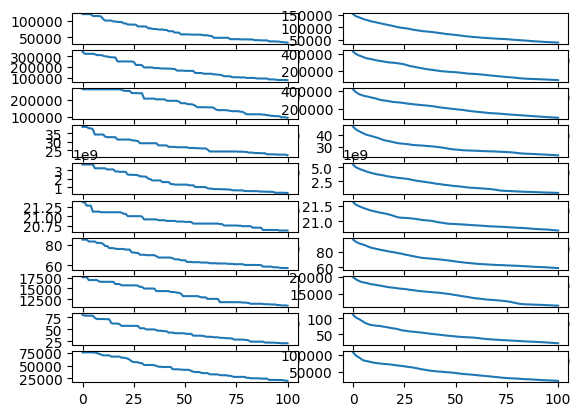

In [122]:
num_tasks = len(cec2017_tasks)
fig, axes = plt.subplots(num_tasks, 2)

for i in range(num_tasks):
    axes[i][0].plot(bfs[i])
    axes[i][1].plot(mfs[i])

In [123]:
x = np.array([True, True, False, False])
np.mean(x)

np.float64(0.5)